In [ ]:
import math
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Sequence, Tuple, Union, Optional, Any, Dict, List, Iterator
import unittest
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt

import numpy as np
import torch

from torch import sigmoid
from torch import nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import argparse
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, random_split
from torch.utils.data import Subset, DataLoader
import random

from torchvision import datasets, models


device: torch.device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device=torch.device("mps")
# device=torch.device("cuda")

print(f"using device: {device}")

rnd_seed = 412
random.seed(rnd_seed)
seed = random.randint(0, 101)
torch.manual_seed(seed)
np.random.seed(seed)

# print(torch.version.cuda)
# print(torch.backends.cudnn.version())
# print(torch.cuda.is_available())

using device: cuda
11.8
90100
True


In [ ]:

DATA_PATH = Path("./one-piece-classification/splitted")
TRAIN_PATH = Path(DATA_PATH / "train") # 
TEST_PATH = Path(DATA_PATH / "test")

In [ ]:
test_images = len(list(TEST_PATH.glob("*")))
print(f"test images: {test_images}")
train_images = len(list(TRAIN_PATH.glob("*/*")))
print(f"train images: {train_images}")
train_labels = len(list(TRAIN_PATH.glob("*")))
print(f"train labels: {train_labels}")

test images: 849
train images: 2915
train labels: 18


In [ ]:
Ace = list(TRAIN_PATH.glob("Ace/*"))
Akainu = list(TRAIN_PATH.glob("Akainu/*"))
Brook = list(TRAIN_PATH.glob("Brook/*"))
Chopper = list(TRAIN_PATH.glob("Chopper/*"))
Crocodile = list(TRAIN_PATH.glob("Crocodile/*"))
Franky = list(TRAIN_PATH.glob("Franky/*"))
Jinbei = list(TRAIN_PATH.glob("Jinbei/*"))
Kurohige = list(TRAIN_PATH.glob("Kurohige/*"))
Law = list(TRAIN_PATH.glob("Law/*"))
Luffy = list(TRAIN_PATH.glob("Luffy/*"))
Mihawk = list(TRAIN_PATH.glob("Mihawk/*"))
Nami = list(TRAIN_PATH.glob("Nami/*"))
Rayleigh = list(TRAIN_PATH.glob("Rayleigh/*"))
Robin = list(TRAIN_PATH.glob("Robin/*"))
Sanji = list(TRAIN_PATH.glob("Sanji/*"))
Shanks = list(TRAIN_PATH.glob("Shanks/*"))
Usopp = list(TRAIN_PATH.glob("Usopp/*"))
Zoro = list(TRAIN_PATH.glob("Zoro/*"))

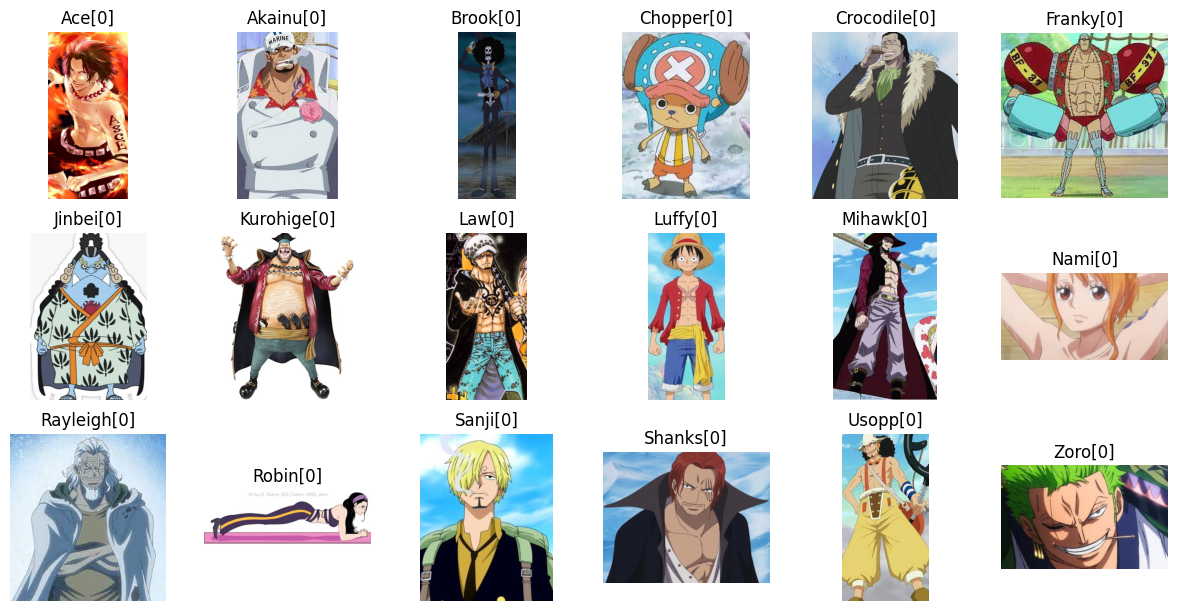

In [ ]:
examples = [Ace[0], Akainu[0], Brook[0], Chopper[0], Crocodile[0], Franky[0], Jinbei[0], Kurohige[0], Law[0], Luffy[0], Mihawk[0], Nami[0], Rayleigh[0], Robin[0], Sanji[0], Shanks[0], Usopp[0], Zoro[0]]

fig = plt.figure(figsize=(15, 10))
cols = 6
rows = 4
c = 0
for ex in examples:
    img = plt.imread(ex)
    ax = fig.add_subplot(rows, cols, c + 1)
    ax.set_title(ex.parent.name+"[0]")
    ax.axis('off')
    ax.imshow(img)
    c = c + 1

    

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

orig_w, orig_h = 256, 256
w, h = 224,224

transforms_orig = transforms.Compose([

    transforms.Resize((orig_w, orig_h)),
    transforms.CenterCrop((w, h)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


transforms_aug = transforms.Compose([
    transforms.RandomResizedCrop((w, h)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.12),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
batch_size = 64

orig_ds = datasets.ImageFolder(root=str(TRAIN_PATH), transform=transforms_orig)
aug_ds = datasets.ImageFolder(root=str(TRAIN_PATH), transform=transforms_aug)
all_ds = ConcatDataset([orig_ds, aug_ds])

total = len(all_ds)
val_size = int(0.2 * total)
train_size = total - val_size
train_ds, val_ds = random_split(all_ds, [train_size, val_size])
val_ds.dataset.transform = transforms_orig # pyright: ignore[reportAttributeAccessIssue]

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

resnet.fc = nn.Linear(resnet.fc.in_features, train_labels)
# print(resnet)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=34)
resnet = resnet.to(device)




In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, scheduler=None):
    time0 = time.time()
    for epoch in range(num_epochs):
        train_loss = .0
        total, true = 0, 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            true += (predicted == labels).sum().item()
            total += labels.size(0)
            
        train_loss = train_loss / len(train_loader.dataset)
        epoch_acc = true / total
        
        # val
       
        model.eval()
        val_loss = .0
        total, true = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                true += (predicted == labels).sum().item()
                total += labels.size(0)
                
        val_loss = val_loss / len(val_loader.dataset)
        epoch_acc = true / total
        
        if scheduler:
            scheduler.step()
        
        time1 = time.time()
        print(f'[{int(time1-time0)}] Epoch {epoch + 1}/{num_epochs}', end = ' ')
        print(f'train Loss: {train_loss:.4f} Train Acc: {epoch_acc:.4f}', end=' ')
        print(f'val Loss: {val_loss:.4f} Val Acc: {epoch_acc:.4f}') 

    return model

In [ ]:
resnet_trained = train_model(resnet, criterion, optimizer, train_loader, val_loader, num_epochs=34, scheduler=scheduler)

[37] Epoch 1/34 train Loss: 1.0662 Train Acc: 0.7993 val Loss: 0.6604 Val Acc: 0.7993
[74] Epoch 2/34 train Loss: 1.2946 Train Acc: 0.6904 val Loss: 0.9741 Val Acc: 0.6904
[110] Epoch 3/34 train Loss: 0.6674 Train Acc: 0.8010 val Loss: 0.6417 Val Acc: 0.8010
[147] Epoch 4/34 train Loss: 0.4626 Train Acc: 0.8379 val Loss: 0.5400 Val Acc: 0.8379
[184] Epoch 5/34 train Loss: 0.4138 Train Acc: 0.8576 val Loss: 0.4544 Val Acc: 0.8576
[221] Epoch 6/34 train Loss: 0.3906 Train Acc: 0.8336 val Loss: 0.5819 Val Acc: 0.8336
[257] Epoch 7/34 train Loss: 0.3616 Train Acc: 0.8533 val Loss: 0.4901 Val Acc: 0.8533
[294] Epoch 8/34 train Loss: 0.3572 Train Acc: 0.8765 val Loss: 0.3948 Val Acc: 0.8765
[330] Epoch 9/34 train Loss: 0.3098 Train Acc: 0.8242 val Loss: 0.6161 Val Acc: 0.8242
[367] Epoch 10/34 train Loss: 0.2736 Train Acc: 0.8979 val Loss: 0.3365 Val Acc: 0.8979
[404] Epoch 11/34 train Loss: 0.2627 Train Acc: 0.8654 val Loss: 0.4540 Val Acc: 0.8654
[441] Epoch 12/34 train Loss: 0.2553 Train 

In [ ]:
import os
from PIL import Image

labels_dict = {class_name:i for class_name, i in orig_ds.class_to_idx.items()}
print(labels_dict)

{'Ace': 0, 'Akainu': 1, 'Brook': 2, 'Chopper': 3, 'Crocodile': 4, 'Franky': 5, 'Jinbei': 6, 'Kurohige': 7, 'Law': 8, 'Luffy': 9, 'Mihawk': 10, 'Nami': 11, 'Rayleigh': 12, 'Robin': 13, 'Sanji': 14, 'Shanks': 15, 'Usopp': 16, 'Zoro': 17}


In [ ]:
SUBMISSION_PATH=Path("./one-piece-classification/submission.csv")
submission_df = pd.read_csv(SUBMISSION_PATH)
transform_pred = transforms.Compose([
    transforms.Resize((orig_w, orig_h)),
    transforms.CenterCrop((w, h)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

with torch.no_grad():
    for i, row in submission_df.iterrows():
        
        img_path = ""
        for ext in [".jpg", ".png", ".jpeg"]:
            pred_path = os.path.join(TEST_PATH, row["id"] + ext)
            if os.path.exists(pred_path):
                img_path = pred_path
                break
        
        if img_path == "":
            print(f"image {row['id']} not found!")
            continue
        
        img = Image.open(img_path).convert("RGB")
        img = transform_pred(img).unsqueeze(0).to(device) # type: ignore
        outputs = resnet_trained(img)
        _, predicted = torch.max(outputs, 1)
        pred_label = datasets.ImageFolder(root=str(TRAIN_PATH)).classes[predicted.item()]
        submission_df.at[i, "label"] = pred_label # type: ignore
        
submission_df["label"] = submission_df["label"].map(labels_dict)
submission_df.to_csv("submission8.csv", index=False)

C:\Users\peopl\AppData\Local\Temp\ipykernel_1784\2083547804.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mihawk' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  submission_df.at[i, "label"] = pred_label # type: ignore


In [ ]:
torch.save(resnet_trained.state_dict(), "resnet18_1.pth"    )